In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

eq5d=pd.read_csv('../rq1/rq1_cleaned_no_ae.csv')


scores=pd.read_excel('../data/Scores 6 Jan 2025_Prescribed_Completed Baseline PROMs.xlsx')
gad7=scores[scores['promName']=='GAD7']
gad7=gad7[['SID','Round','promName','total_score','completionDate']]


gad7_wide = gad7.pivot_table(index='SID', 
                                    columns='Round', 
                                    values='total_score', 
                                    aggfunc='first')

gad7_wide.columns = [f"GAD7_Round{r}" for r in gad7_wide.columns]
gad7_wide = gad7_wide.reset_index()
gad7= pd.merge(eq5d, gad7_wide, on='SID', how='left')
gad7=gad7.rename(columns={'GAD7_Round1_y': 'GAD7_Round1',})

insomnia=scores[scores['promName']=='insomniaEfficacyMeasure']
insomnia=insomnia[['SID','Round','promName','total_score','completionDate']]


insomnia_wide = insomnia.pivot_table(index='SID', 
                                    columns='Round', 
                                    values='total_score', 
                                    aggfunc='first')

insomnia_wide.columns = [f"insomniaEfficacyMeasure_Round{r}" for r in insomnia_wide.columns]
insomnia_wide = insomnia_wide.reset_index()
insomnia_wide= pd.merge(gad7, insomnia_wide, on='SID', how='left')
insomnia=insomnia_wide.rename(columns={'insomniaEfficacyMeasure_Round1_y': 'insomniaEfficacyMeasure_Round1',})
full=insomnia.copy()


Round 2

In [2]:
full.columns.tolist()

['SID',
 'EQ5D_Round1',
 'EQ5D_Round2',
 'EQ5D_Round3',
 'EQ5D_Round4',
 'EQ5D_Round5',
 'EQ5D_Round6',
 'Age',
 'Sex',
 'occupation',
 'weight',
 'height',
 'Myocardial_infarction',
 'Congestive_heart_failure',
 'Peripheral_vascular_disease',
 'Cerebrovascular_accident_or_transient_ischemic_attack',
 'Dementia',
 'Chronic_obstructive_pulmonary_disease',
 'Connective_tissue_disease',
 'Peptic_Ulcer_Disease',
 'Liver_disease',
 'Diabetes',
 'Hemiplegia',
 'Moderate_to_severe_chronic_kidney_disease',
 'Solid_tumour',
 'Leukemia',
 'Lymphoma',
 'AIDS',
 'Charlson_comorbidity',
 'Hypertension',
 'Depression_or_anxiety',
 'Arthritis',
 'Epilepsy',
 'VTE',
 'Endocrine_thyroid_dysfunction',
 'Allergy',
 'Smoking_status',
 'Smoking_pack_years',
 'alcohol_units',
 'Cannabis_status',
 'GAD7_Round1_x',
 'insomniaEfficacyMeasure_Round1_x',
 'diag_Depression',
 'diag_Anxiety',
 'diag_Chronic pain',
 'diag_Osteoarthritis',
 'diag_PTSD',
 'diag_Fibromyalgia',
 'diag_Multiple sclerosis',
 'diag_Neurop

In [4]:
## Splitting into train and test
from sklearn.model_selection import train_test_split

X = full.drop(columns=[
    'SID', 
    'GAD7_Round2', 'GAD7_Round3', 'GAD7_Round4', 'GAD7_Round5',
    'GAD7_Round6', 'GAD7_Round7', 'GAD7_Round8', 'GAD7_Round9',
    'GAD7_Round10', 'GAD7_Round11', 'GAD7_Round12', 'GAD7_Round13',
    'EQ5D_Round2','EQ5D_Round3', 'EQ5D_Round4', 'EQ5D_Round5', 'EQ5D_Round6', 'GAD7_Round1_x','insomniaEfficacyMeasure_Round2',
 'insomniaEfficacyMeasure_Round3',
 'insomniaEfficacyMeasure_Round4',
 'insomniaEfficacyMeasure_Round5',
 'insomniaEfficacyMeasure_Round6',
 'insomniaEfficacyMeasure_Round7',
 'insomniaEfficacyMeasure_Round8',
 'insomniaEfficacyMeasure_Round9',
 'insomniaEfficacyMeasure_Round10',
 'insomniaEfficacyMeasure_Round11',
 'insomniaEfficacyMeasure_Round12',
 'insomniaEfficacyMeasure_Round13'
])
y = full['EQ5D_Round2']

data = pd.concat([X, y], axis=1).dropna()
X = data.drop(columns='EQ5D_Round2')
y = data['EQ5D_Round2']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def get_models_and_grids():
    models = {
        'Ridge': Ridge(random_state=0),
        'Lasso': Lasso(random_state=0),
        'RandomForest': RandomForestRegressor(random_state=42),
        'XGB': XGBRegressor(objective='reg:squarederror', random_state=42)
    }
    grids = {
        'Ridge': {'alpha': [0.1, 1.0, 10.0]},
        'Lasso': {'alpha': [0.01, 0.1, 1.0]},
        'RandomForest': {'n_estimators': [100, 200], 'max_depth': [None, 5, 10]},
        'XGB': {'n_estimators': [100, 200], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]}
    }
    return models, grids

models, grids = get_models_and_grids()

outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=2)

ensemble_results = {}
for name, model in models.items():
    grid = GridSearchCV(
        estimator=model,
        param_grid=grids[name],
        cv=inner_cv,
        scoring='r2',
        n_jobs=-1
    )
    r2_scores = []
    mse_scores = []
    for train_idx, test_idx in outer_cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Hyperparameter tuning
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_

        # Evaluation on held-out fold
        preds = best_model.predict(X_test)
        r2_scores.append(r2_score(y_test, preds))
        mse_scores.append(mean_squared_error(y_test, preds))

    ensemble_results[name] = {
        'best_params': grid.best_params_,
        'r2_mean': np.mean(r2_scores),
        'r2_std': np.std(r2_scores),
        'mse_mean': np.mean(mse_scores),
        'mse_std': np.std(mse_scores)
    }


import pprint
pprint.pprint(ensemble_results)


{'Lasso': {'best_params': {'alpha': 0.01},
           'mse_mean': 0.04435678404455838,
           'mse_std': 0.0007536913086444004,
           'r2_mean': 0.41089230724282616,
           'r2_std': 0.009296132240375208},
 'RandomForest': {'best_params': {'max_depth': 10, 'n_estimators': 200},
                  'mse_mean': 0.04210271424329297,
                  'mse_std': 0.0009058005539132363,
                  'r2_mean': 0.4407863321797766,
                  'r2_std': 0.013423200876617794},
 'Ridge': {'best_params': {'alpha': 10.0},
           'mse_mean': 0.04227257556589826,
           'mse_std': 0.0006758811786199062,
           'r2_mean': 0.4384894219540728,
           'r2_std': 0.01271656662307049},
 'XGB': {'best_params': {'learning_rate': 0.1,
                         'max_depth': 3,
                         'n_estimators': 100},
         'mse_mean': 0.04132345464238018,
         'mse_std': 0.0008940698116672119,
         'r2_mean': 0.45110511575750056,
         'r2_std': 0.014483

In [10]:
import pandas as pd
import json

results = json.load(open('results/eq5d_round2_results.json'))
df = pd.DataFrame(results)
df

,Ridge,Lasso,RandomForest,XGB
best_params,{'alpha': 10.0},{'alpha': 0.01},"{'max_depth': 5, 'n_estimators': 200}","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
r2_mean,0.631289,0.607029,0.632603,0.63649
r2_std,0.015587,0.01114,0.01746,0.016483
mse_mean,0.025258,0.026945,0.025155,0.024896
mse_std,0.000872,0.00125,0.000666,0.000801
mae_mean,0.116534,0.122485,0.115781,0.115074
mae_std,0.001553,0.002152,0.001234,0.001646


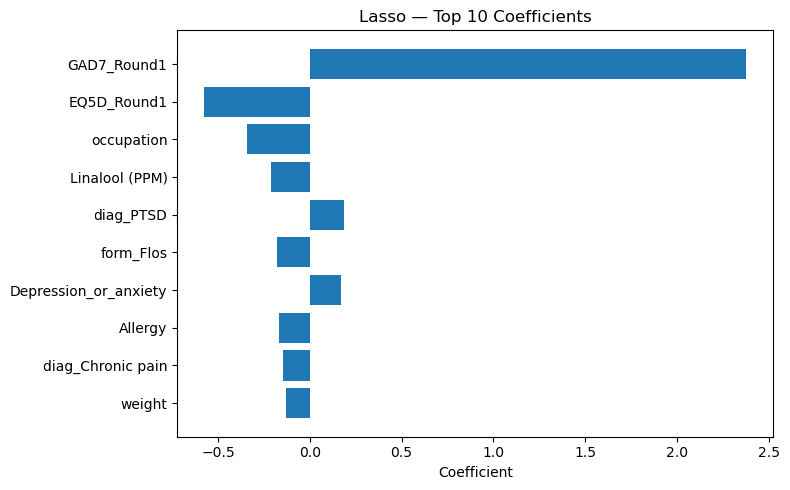

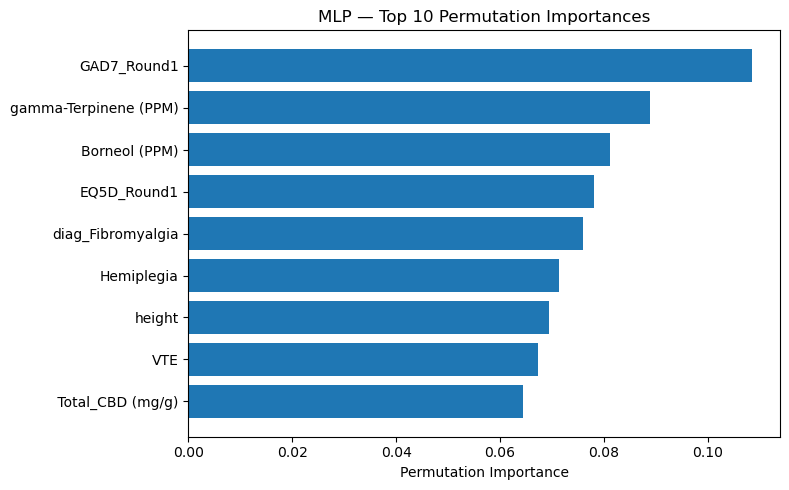

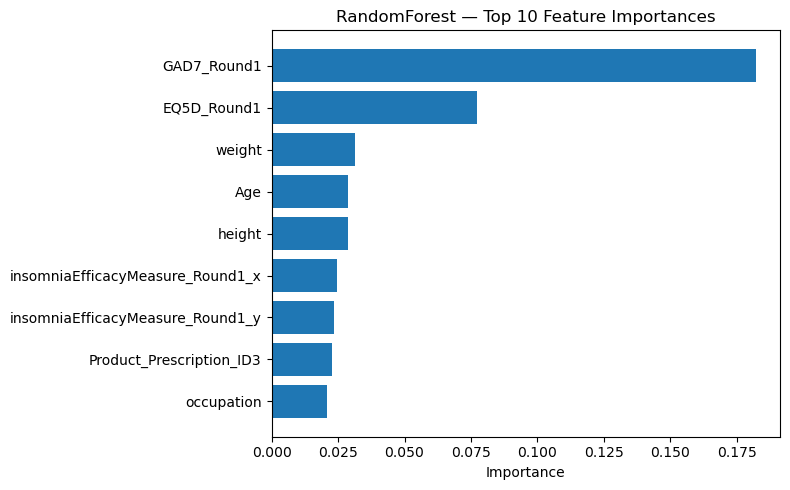

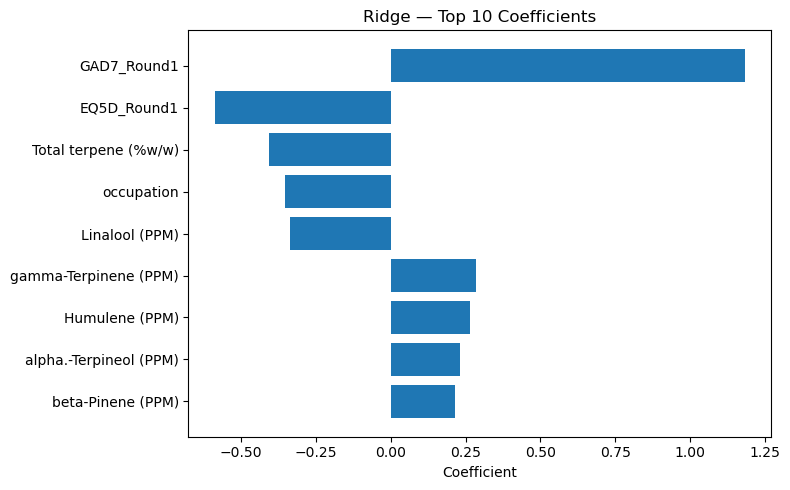

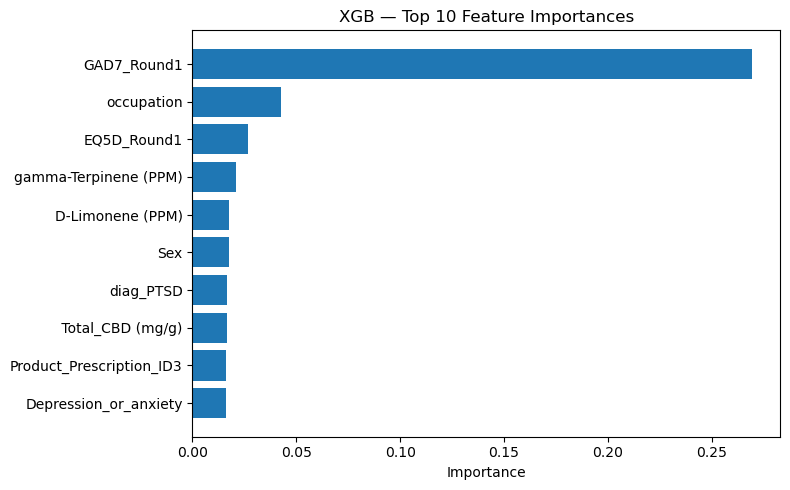

ValueError: All arrays must be of the same length

In [24]:

# Load saved models and plot top predictors
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# 1) Reconstruct feature names exactly as in training
# Load raw data
import pandas as pd

drop_cols = [
    'SID', 'GAD7_Round2','GAD7_Round3','GAD7_Round4','GAD7_Round5',
    'GAD7_Round6','GAD7_Round7','GAD7_Round8','GAD7_Round9','GAD7_Round10',
    'GAD7_Round11','GAD7_Round12','GAD7_Round13',
    'EQ5D_Round2','EQ5D_Round3','EQ5D_Round4','EQ5D_Round5','EQ5D_Round6',
    'insomniaEfficacyMeasure_Round2',
    'insomniaEfficacyMeasure_Round3','insomniaEfficacyMeasure_Round4',
    'insomniaEfficacyMeasure_Round5','insomniaEfficacyMeasure_Round6',
    'insomniaEfficacyMeasure_Round7','insomniaEfficacyMeasure_Round8',
    'insomniaEfficacyMeasure_Round9','insomniaEfficacyMeasure_Round10',
    'insomniaEfficacyMeasure_Round11','insomniaEfficacyMeasure_Round12',
    'insomniaEfficacyMeasure_Round13'
]
X = full.drop(columns=drop_cols)
feature_names = X.columns.tolist()

# 1b) Reconstruct target aligned with X
# Use the same y used in training
y = full['GAD7_Round2']

# 2) Load saved models and plot their top predictors
from sklearn.inspection import permutation_importance

dir_path = '/rds/general/user/hsl121/home/hda_project/final_pipeline/results/models'
for fname in sorted(os.listdir(dir_path)):
    if not fname.endswith('.pkl'):
        continue
    model_label = fname.replace('.pkl','')
    pipeline = joblib.load(os.path.join(dir_path, fname))
    model = pipeline.named_steps['model']

    # Build DataFrame of importances or coefficients
    if hasattr(model, 'feature_importances_'):
        vals = model.feature_importances_
        df = pd.DataFrame({'feature': feature_names, 'importance': vals})
        df = df.sort_values('importance', ascending=False).head(10)
        title = f"{model_label} — Top 10 Feature Importances"
        x = df['importance']
        xlabel = 'Importance'
    elif hasattr(model, 'coef_'):
        coefs = model.coef_.flatten()
        df = pd.DataFrame({'feature': feature_names, 'coef': coefs})
        df['importance'] = df['coef'].abs()
        df = df.sort_values('importance', ascending=False).head(10)
        title = f"{model_label} — Top 10 Coefficients"
        x = df['coef']
        xlabel = 'Coefficient'
    else:
        # Permutation importance
        X_sample = X.sample(n=min(200, len(X)), random_state=42)
        y_sample = y.loc[X_sample.index]
        r = permutation_importance(
            pipeline, X_sample, y_sample,
            n_repeats=10, random_state=42, n_jobs=-1
        )
        df = pd.DataFrame({'feature': feature_names, 'importance': r.importances_mean})
        df = df.sort_values('importance', ascending=False).head(10)
        title = f"{model_label} — Top 10 Permutation Importances"
        x = df['importance']
        xlabel = 'Permutation Importance'

    # Rename any misnamed features
    df['feature'] = df['feature'].str.replace('GAD7_Round1_y', 'GAD7_Round1')
    df['feature'] = df['feature'].str.replace('GAD7_Round1_x', 'GAD7_Round1')

    # Plot horizontal bar chart
    fig, ax = plt.subplots(figsize=(8,5))
    ax.barh(df['feature'][::-1], x[::-1])
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()



In [17]:
X.columns.tolist()

['EQ5D_Round1',
 'Age',
 'Sex',
 'occupation',
 'weight',
 'height',
 'Myocardial_infarction',
 'Congestive_heart_failure',
 'Peripheral_vascular_disease',
 'Cerebrovascular_accident_or_transient_ischemic_attack',
 'Dementia',
 'Chronic_obstructive_pulmonary_disease',
 'Connective_tissue_disease',
 'Peptic_Ulcer_Disease',
 'Liver_disease',
 'Diabetes',
 'Hemiplegia',
 'Moderate_to_severe_chronic_kidney_disease',
 'Solid_tumour',
 'Leukemia',
 'Lymphoma',
 'AIDS',
 'Charlson_comorbidity',
 'Hypertension',
 'Depression_or_anxiety',
 'Arthritis',
 'Epilepsy',
 'VTE',
 'Endocrine_thyroid_dysfunction',
 'Allergy',
 'Smoking_status',
 'Smoking_pack_years',
 'alcohol_units',
 'Cannabis_status',
 'GAD7_Round1_x',
 'insomniaEfficacyMeasure_Round1_x',
 'diag_Depression',
 'diag_Anxiety',
 'diag_Chronic pain',
 'diag_Osteoarthritis',
 'diag_PTSD',
 'diag_Fibromyalgia',
 'diag_Multiple sclerosis',
 'diag_Neuropathic pain',
 'diag_Attention deficit hyperactivity disorder',
 'diag_Migraine',
 'diag_